In [ ]:
!pip install noisereduce

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce as nr


from IPython.display import Audio,clear_output
from IPython.core.display import display

In [ ]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def play_box(audio,rate, text=""):
  print(text)
  display(Audio(audio,rate=rate, autoplay=False))


In [ ]:
def process_bar(index, tottal, step= 50, massage=""):
  if index % step == 0:

    clear_output()
    percent = index/tottal * 100
    print("_"*105)
    print(percent,"%")
    print(f"{index+1}/{tottal}")
    print(f"[{'#'*int(percent)}{'-'*int(101 - percent)}]")
    print("_"*105)
    print(massage)



In [ ]:
def evaluation(label_test , label_pred):
  results = {
      "RMSE":np.sqrt(np.mean((label_test - label_pred) ** 2)),
      "r2_score":r2_score(label_test , label_pred)
  }
  return results

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/development.csv')

In [ ]:
# @title this function help to find out how many null value exist in each column

def get_null_values(df):
  result = df.isnull().sum()
  result = result[result > 0]
  return result

In [ ]:
print(get_null_values(df))


Series([], dtype: int64)


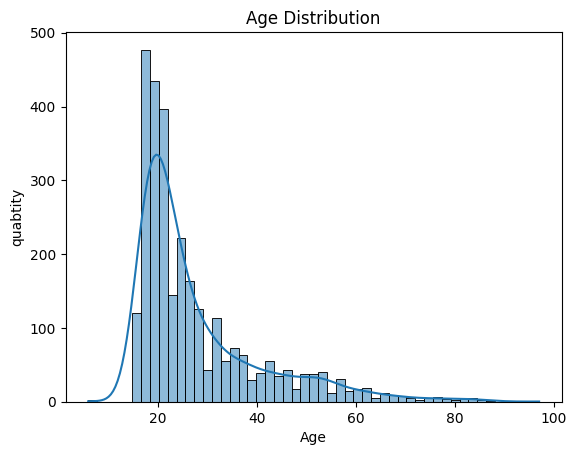

In [ ]:
# @title visualization  of age distribution in data set

sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('quabtity')
plt.show()



In this section we clean or data and prepare given csv

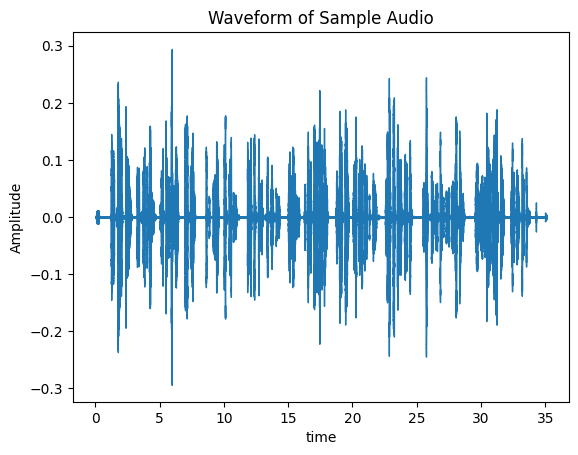

In [ ]:
# @title loading a sample file
y, sr = librosa.load("/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/audios_development/1.wav", sr=1600)
librosa.display.waveshow(y, sr=sr )
plt.title('Waveform of Sample Audio')
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.show()

onset


(19,)


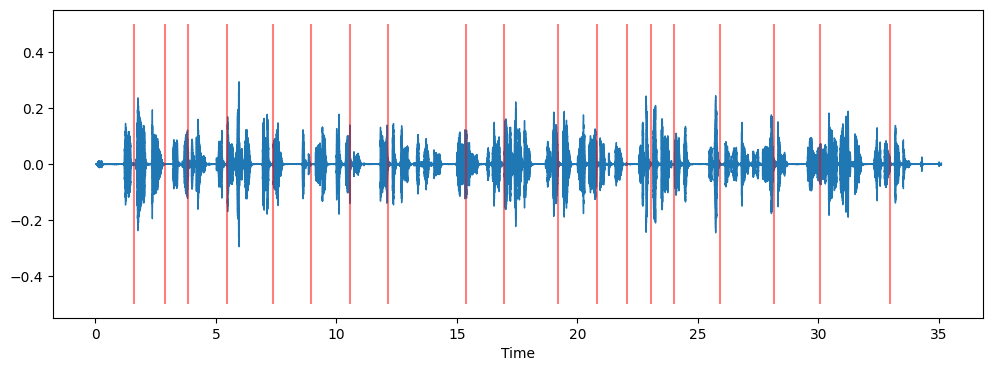

In [ ]:
# @title onset detection

def get_onset(audio, sample_rate):
    o_env = librosa.onset.onset_strength(y=audio, sr=sample_rate)
    onset = librosa.onset.onset_detect(onset_envelope=o_env, sr=sample_rate, units="time", wait=1,pre_avg=1, post_avg=1, pre_max=1, post_max=1 , backtrack=False)
    return onset

onset = get_onset(y, sr)

clicks = librosa.clicks(times=onset, sr=sr, length=len(y))

play_box(y + clicks, sr,"onset")

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, axis="time")

print(onset.shape)
for o in onset:
  plt.vlines(o, -0.5, 0.5, alpha= 0.5, colors="r")
plt.show()





In [ ]:
# @title data cleaning

a = len(df)
pre_path = '/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/'
drop_list = []
for i in range(len(df)):
  process_bar(i,len(df),massage="cleaning data...")
  if df["num_words"].iloc[i]< 10:
      drop_list.append(i)
  # else:
  #   audio , sample_rate = librosa.load(pre_path+df['path'].iloc[i], sr=1600)
    # if get_onset(audio, sample_rate).shape[0]< 5:
    #   drop_list.append(i)
df.drop(drop_list, inplace=True)
df.reset_index(drop=True, inplace=True)


print(f"{a} sample before data cleaning")
print(f"{len(df)} sample after data cleaning")
# del audio , sample_rate, a

_________________________________________________________________________________________________________
98.87487214456189 %
2901/2933
[##################################################################################################--]
_________________________________________________________________________________________________________
cleaning data...
2933 sample before data cleaning
1712 sample after data cleaning


In [ ]:
# @title Data normalaizer

def feature_normalization(data, columns ):
  scaler = StandardScaler()
  # scaler = QuantileTransformer()

  data[columns] = scaler.fit_transform(data[columns])
  return data



In [ ]:
# @title select and tansform data
defult_features = [
        'mean_pitch',
        'max_pitch',
        'min_pitch',
        'jitter',
        'shimmer',
        'energy',
        'zcr_mean',
        'spectral_centroid_mean',
        'tempo',
]
# defult_features = [
#         'mean_pitch',
#         'max_pitch',
#         'min_pitch',
#         'jitter',
#         'shimmer',
#         'energy',
#         'zcr_mean',
#         'spectral_centroid_mean',
#         'tempo',
#         'hnr',
#         'num_words',
#         'num_characters',
#         'num_pauses',
#         'silence_duration'
# ]

df['tempo'] = df['tempo'].str.strip('[]').astype(float)

df= feature_normalization(df,defult_features)
df.head()

,Id,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,24.0,female,arabic,1.260555,0.076048,-0.297565,-1.493121,-1.185473,-0.682995,1.732236,1.404505,1.239932,-123.999726,69,281,39,23.846893,audios_development/1.wav
1,1,22050,22.5,female,hungarian,-0.431136,0.053579,-0.409314,0.322824,-0.692801,0.361408,-1.274653,-1.131605,0.316520,-86.928478,69,281,21,19.388662,audios_development/2.wav
2,2,22050,22.0,female,portuguese,-0.318004,0.052100,-0.310498,-0.664377,0.153290,-0.547776,-0.667157,0.451211,-0.159177,-98.450670,69,281,1,21.640998,audios_development/3.wav
3,3,22050,22.0,female,english,-0.003165,0.042895,4.617547,-0.988736,-0.468763,3.092497,0.898466,1.684951,-0.159177,-56.459762,69,281,9,19.644127,audios_development/4.wav
4,4,22050,22.0,male,dutch,0.831176,0.047093,-0.264684,0.743867,0.349206,-0.098408,-0.623300,-0.699113,-0.366002,-80.349204,69,281,11,18.041905,audios_development/5.wav


In [ ]:
# @title one_hot encoding for categurical features
df = pd.get_dummies(df, columns=['gender', 'ethnicity'], drop_first=True)
df.head()

,Id,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,...,ethnicity_quechua,ethnicity_romanian,ethnicity_rotuman,ethnicity_rundi,ethnicity_russian,ethnicity_rwanda,ethnicity_sa'a,ethnicity_sardinian,ethnicity_sarua,ethnicity_satawalese
0,0,22050,24.0,1.260555,0.076048,-0.297565,-1.493121,-1.185473,-0.682995,1.732236,...,False,False,False,False,False,False,False,False,False,False
1,1,22050,22.5,-0.431136,0.053579,-0.409314,0.322824,-0.692801,0.361408,-1.274653,...,False,False,False,False,False,False,False,False,False,False
2,2,22050,22.0,-0.318004,0.052100,-0.310498,-0.664377,0.153290,-0.547776,-0.667157,...,False,False,False,False,False,False,False,False,False,False
3,3,22050,22.0,-0.003165,0.042895,4.617547,-0.988736,-0.468763,3.092497,0.898466,...,False,False,False,False,False,False,False,False,False,False
4,4,22050,22.0,0.831176,0.047093,-0.264684,0.743867,0.349206,-0.098408,-0.623300,...,False,False,False,False,False,False,False,False,False,False


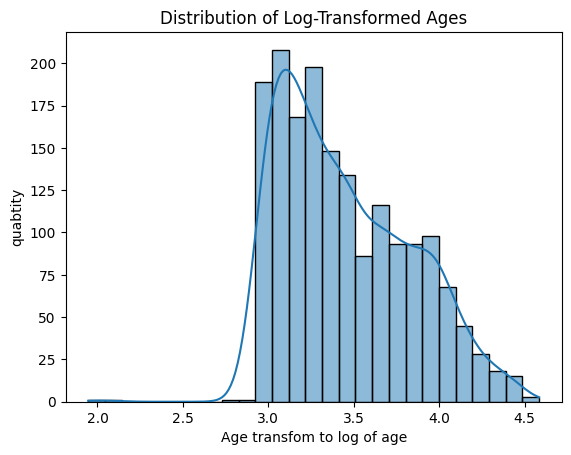

In [ ]:
# @title we transform age using  natural logarithm to privent out layers
df['age_transfom'] = np.log1p(df['age'])
sns.histplot(df['age_transfom'], kde=True)
plt.title('Distribution of Log-Transformed Ages')
plt.xlabel('Age transfom to log of age')
plt.ylabel('quabtity')
plt.show()

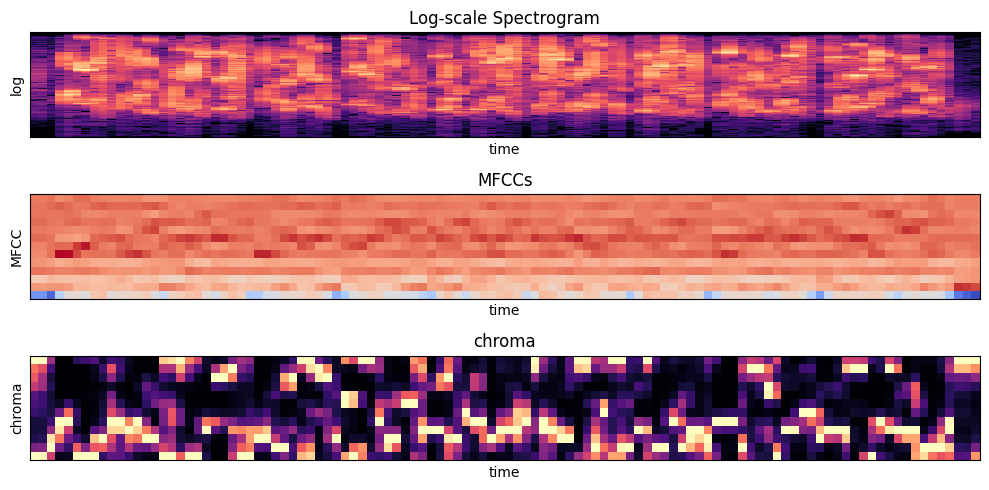

In [ ]:
# @title features of a single sample

fig, axs = plt.subplots(3,1,figsize=(10, 5))

spec = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
spec_im = librosa.display.specshow(spec, sr=sr , ax=axs[0])
axs[0].set_xlabel('time')
axs[0].set_ylabel('log')
axs[0].set_title('Log-scale Spectrogram')

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
librosa.display.specshow(mfccs, ax=axs[1])
axs[1].set_xlabel('time')
axs[1].set_ylabel('MFCC')
axs[1].set_title('MFCCs')


chroma = librosa.feature.chroma_stft(y=y, sr=sr)
librosa.display.specshow(chroma, ax=axs[2])
axs[2].set_xlabel('time')
axs[2].set_ylabel('chroma')
axs[2].set_title('chroma')


plt.tight_layout()
plt.show()



original


noise removed


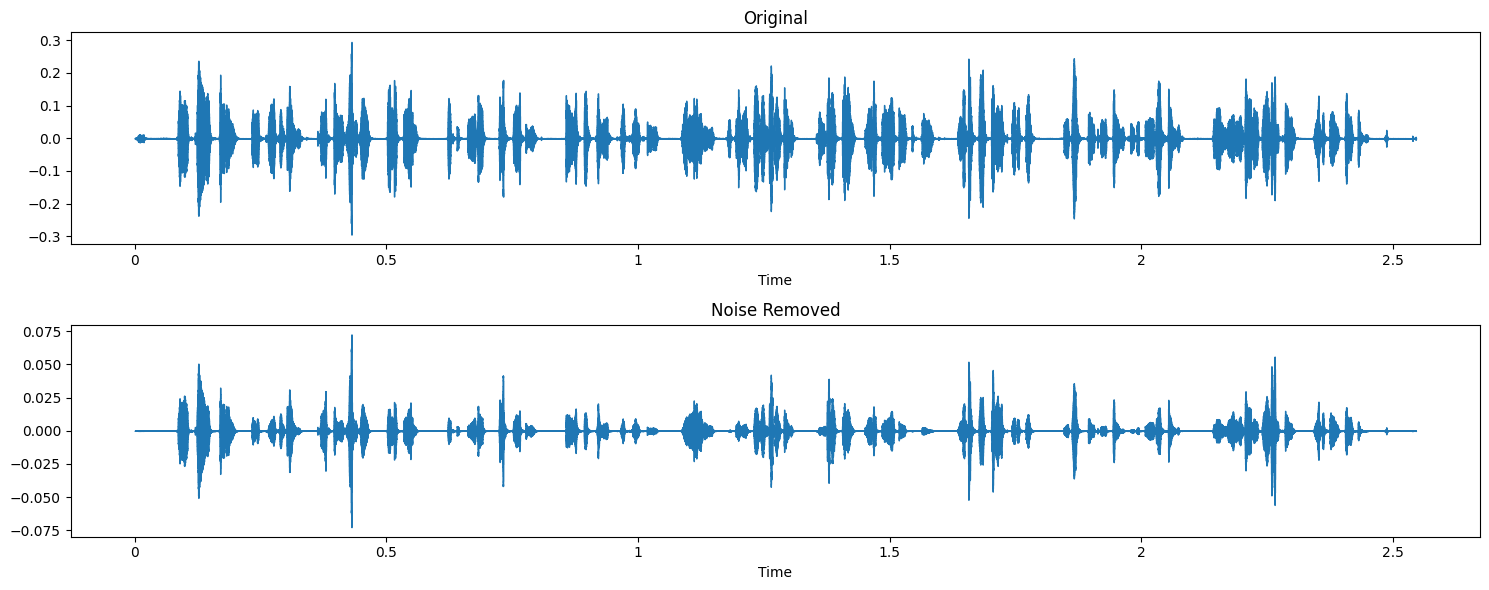

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(15, 6))


reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=False,time_mask_smooth_ms=160)
librosa.display.waveshow(y, ax=axs[0])
librosa.display.waveshow(reduced_noise,  ax=axs[1])

play_box(y, sr,"original")
play_box(reduced_noise, sr,"noise removed")

axs[0].set_title("Original")
axs[1].set_title("Noise Removed")

plt.tight_layout()
plt.show()




In [ ]:
# @title extraxtion of a single audio file
def get_audio_features(audio,sample_rate):
  audio = nr.reduce_noise(y=audio, sr=sample_rate, stationary=False,time_mask_smooth_ms=160)

  mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
  mfccs_avg = np.mean(mfccs, axis=1)

  chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
  chroma_avg = np.mean(chroma, axis=1)


  spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))


  features = np.hstack([mfccs_avg, chroma_avg,np.array([spectral_centroid,spectral_bandwidth])])
  return features
print(get_audio_features(y,sr).shape)

(27,)


In [ ]:
# @title feature extraction across the dataset
def feature_extractor(data):
  scaler = StandardScaler()
  pre_path = '/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/'

  audio , sample_rate = librosa.load(pre_path+data['path'][0], sr=1600)

  extracted_features = get_audio_features(audio , sample_rate)
  for i in range(1,len(data)):
    process_bar(i,len(data),massage="feature extraction...")
    audio , sample_rate = librosa.load(pre_path+data['path'][i], sr=1600)
    extracted_features = np.vstack([extracted_features, get_audio_features(audio , sample_rate)])

  columns_name = ["mfcc_" + str(c)  for c in range(1,14)] + ["chroma_" + str(c)  for c in range(1,13)]
  columns_name.append("spectral_centroid")
  columns_name.append("spectral_bandwidth")
  extracted_features = scaler.fit_transform(extracted_features)
  return pd.DataFrame(extracted_features, columns=columns_name)


In [ ]:

df = pd.concat([df, feature_extractor(df)], axis=1)
df.head()
# df = feature_normalization(df,defult_features)
df.to_csv('/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/development_with_features.csv', index=False)


_________________________________________________________________________________________________________
99.29906542056075 %
1701/1712
[###################################################################################################-]
_________________________________________________________________________________________________________
feature extraction...


In [ ]:
df.head()

,Id,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,...,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,spectral_centroid,spectral_bandwidth
0,0,22050,24.0,1.260555,0.076048,-0.297565,-1.493121,-1.185473,-0.682995,1.732236,...,0.709979,-0.679826,-1.237708,-1.343973,-1.336765,-0.881514,-0.186249,-0.028310,-1.176659e-11,3.808509e-12
1,1,22050,22.5,-0.431136,0.053579,-0.409314,0.322824,-0.692801,0.361408,-1.274653,...,-0.589988,-0.897632,-0.016402,1.917237,1.699116,0.851405,-0.009968,-0.595008,-1.176659e-11,3.808509e-12
2,2,22050,22.0,-0.318004,0.052100,-0.310498,-0.664377,0.153290,-0.547776,-0.667157,...,-1.234701,-1.758044,-0.606258,0.152374,0.009426,0.700789,0.770547,0.795299,-1.176659e-11,3.808509e-12
3,3,22050,22.0,-0.003165,0.042895,4.617547,-0.988736,-0.468763,3.092497,0.898466,...,0.868833,-0.614327,-0.762113,-1.757625,-1.162294,-0.050293,0.538492,-0.780895,-1.176659e-11,3.808509e-12
4,4,22050,22.0,0.831176,0.047093,-0.264684,0.743867,0.349206,-0.098408,-0.623300,...,-0.181356,-0.789340,-0.524622,1.615109,2.329743,0.728597,0.409115,1.062235,-1.176659e-11,3.808509e-12


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/development_with_features.csv')

id = df['Id']
paths = df['path']
label = df['age_transfom']
# X = df.drop(columns=['age',"age_transfom", 'path', 'Id','sampling_rate', ])
X = df.drop(columns=['age',"age_transfom", 'path', 'Id','sampling_rate','num_words',"silence_duration","num_pauses", 'num_characters'])


af_X_train, af_X_test, af_y_train, af_y_test = train_test_split(X, label, test_size=0.2, random_state=42)
# print(list(X.columns))



Number of features: 187
List of 10 best features ordered by impact on label:
mfcc_7                    0.054092
mfcc_4                    0.051399
hnr                       0.041865
mfcc_10                   0.039430
mfcc_11                   0.037715
mfcc_6                    0.035273
mfcc_3                    0.033994
spectral_centroid_mean    0.033120
shimmer                   0.030259
energy                    0.029397
dtype: float64


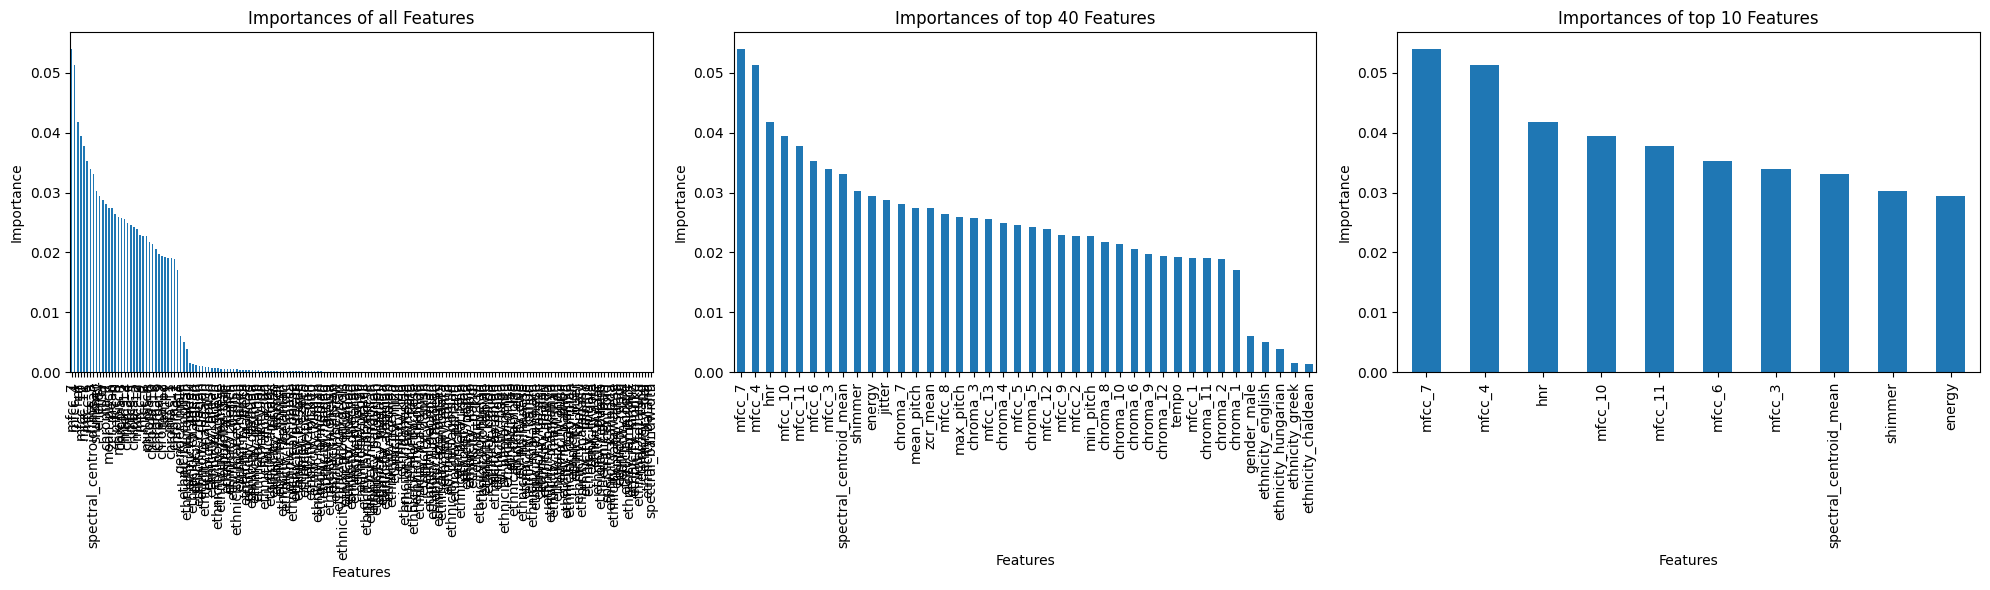

we have chosen 52 first features
list of our feature list is['mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean', 'spectral_centroid_mean', 'tempo', 'hnr', 'gender_male', 'ethnicity_arabic', 'ethnicity_chaldean', 'ethnicity_croatian', 'ethnicity_dari', 'ethnicity_dutch', 'ethnicity_english', 'ethnicity_french', 'ethnicity_greek', 'ethnicity_hungarian', 'ethnicity_italian', 'ethnicity_japanese', 'ethnicity_korean', 'ethnicity_mandarin', 'ethnicity_polish', 'ethnicity_portuguese', 'ethnicity_russian', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12']


In [ ]:
# @title we need to find the features which have more coeffitions on age
# @markdown is this section using RandomForestRegressor we can indicate features with most coeffition on label and as it is notable in plots impact will drop drastically after 40 most related features and 10 top features has most share of impact so we choose or feature set based on this measurement

# @markdown we choose features that hava impact higher that 0.0005
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(af_X_train, af_y_train)


feature_importances = pd.Series(rf.feature_importances_, index=af_X_train.columns)
print(f"Number of features: {len(feature_importances)}")
print("List of 10 best features ordered by impact on label:")
print(feature_importances.sort_values(ascending=False).head(10))


fig, ax = plt.subplots(1,3,figsize=(20, 6))

all_features = feature_importances.sort_values(ascending=False).head(len(feature_importances))
top_40_features = feature_importances.sort_values(ascending=False).head(40)
top_10_features = feature_importances.sort_values(ascending=False).head(10)

all_features.plot(kind='bar', title='Importances of all Features' , ax=ax[0])
top_40_features.plot(kind='bar', title='Importances of top 40 Features' , ax=ax[1])
top_10_features.plot(kind='bar', title='Importances of top 10 Features' , ax=ax[2])

ax[0].set_xlabel('Features')
ax[0].set_ylabel('Importance')

ax[1].set_xlabel('Features')
ax[1].set_ylabel('Importance')

ax[2].set_xlabel('Features')
ax[2].set_ylabel('Importance')

plt.tight_layout()

plt.show()

mask = feature_importances[feature_importances > 0.0005].index



X_train, X_test, y_train, y_test = train_test_split(X[mask], label, test_size=0.2, random_state=42)
print(f"we have chosen {len(mask)} first features")

print(f"list of our feature list is{list(X[mask].columns)}")

In [ ]:
# @title testing different models to get most accurat own

dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

dt_model.fit(X_train, y_train)
y_predict_dt = dt_model.predict(X_test)
dt_rmse = evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_predict_dt))
print(f"Decision Tree results: {dt_rmse}")


rf_model.fit(X_train, y_train)
y_predict_rf = rf_model.predict(X_test)
np.expm1(y_predict_dt)

rf_rmse = evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_predict_rf))
print(f"Random Forest results: {rf_rmse}")

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_predict_ridge = ridge_model.predict(X_test)

ridge_rmse = evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_predict_ridge))
print(f"Ridge results: {ridge_rmse}")



gbr = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=3, learning_rate=0.1)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

gbr_rmse = evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_pred_gbr))
print(f"Gradient Boosting results: {gbr_rmse}")



pipeline = Pipeline([
            ('pca', PCA(n_components=50)),
            ('classifier', LinearRegression())
        ])
pipeline.fit(X_train, y_train)
y_pred_lr = pipeline.predict(X_test)

lr_rmse = evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_pred_lr))
print(f"Linear Regression results: {lr_rmse}")



Decision Tree results: {'RMSE': 18.757175497741155, 'r2_score': -0.6470980859963156}
Random Forest results: {'RMSE': 14.05617690469786, 'r2_score': 0.07504840082541309}
Ridge results: {'RMSE': 13.864117849130064, 'r2_score': 0.10015219506557227}
Gradient Boosting results: {'RMSE': 14.226904816758092, 'r2_score': 0.05244281135275519}
Linear Regression results: {'RMSE': 13.866400918534383, 'r2_score': 0.09985580633468716}


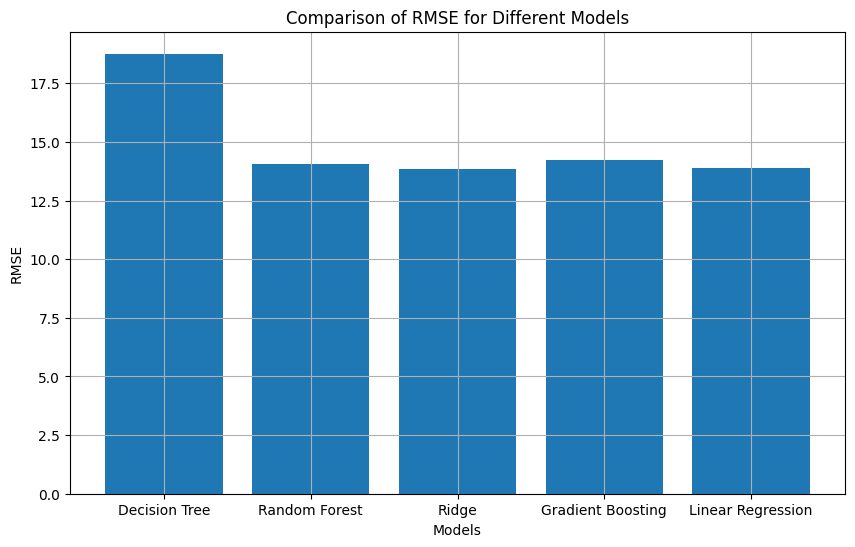

In [ ]:
models = ['Decision Tree', 'Random Forest', 'Ridge', 'Gradient Boosting' , "Linear Regression"]
rmse_values = [dt_rmse["RMSE"], rf_rmse["RMSE"], ridge_rmse["RMSE"], gbr_rmse["RMSE"] , lr_rmse["RMSE"]]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values )
plt.grid(True)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for Different Models')
plt.show()

In [ ]:
# @title Using GridSearchCV to find best parameters for GradientBoostingRegressor model

kfold = KFold(n_splits=10, shuffle=True, random_state=42)


gbr_model = GradientBoostingRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=kfold,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Parameters:", best_params)
print("Best RMSE (Log Scale):", best_rmse)

final_gbr = GradientBoostingRegressor(**best_params, random_state=42)
final_gbr.fit(X_train, y_train)


y_pred_gbr = final_gbr.predict(X_test)

y_pred_gbr_original = np.expm1(y_pred_gbr)
y_val_original = np.expm1(y_test)

rmse_gbr_original = evaluation(label_test=np.expm1(y_pred_gbr_original),label_pred=np.expm1(y_pred_gbr_original))


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE (Log Scale): 0.3222027842839023


In [ ]:
# @title Best parameters for GradientBoostingRegressor
final_gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)


In [ ]:
# @title Fitting GradientBoostingRegressor with best parameters
final_gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)
print(f"Gradient Boosting RMSE: {evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_pred_gbr))}")


Gradient Boosting RMSE: {'RMSE': 12.787874265767602, 'r2_score': 0.23443636846491867}


In [ ]:
# @title Using GridSearchCV to find best parameters for Ridge model
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'sag', 'lsqr'],
    'fit_intercept': [True, False],
    'tol': [1e-3, 1e-4]
}

ridge_model = Ridge()
grid_search = GridSearchCV(ridge_model,
                           param_grid,
                           cv=kfold,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params_ridge = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best Parameters:", best_params_ridge)
print("Best RMSE (Log Scale):", best_rmse)

final_ridge = Ridge(**best_params_ridge)
final_ridge.fit(X_train, y_train)


Best Parameters: {'alpha': 100, 'fit_intercept': True, 'solver': 'sag', 'tol': 0.001}
Best RMSE (Log Scale): 0.331878721388022


Ridge(alpha=100, solver='sag', tol=0.001)

In [ ]:
# @title Best parameters for Ridge
final_ridge =Ridge(alpha=100,
                   solver='sag',
                   tol=0.001)

In [ ]:
# @title Fitting Ridge with best parameters
final_ridge.fit(X_train, y_train)

y_pred_ridge = final_ridge.predict(X_test)
print(f"Ridge RMSE: {evaluation(label_test=np.expm1(y_test),label_pred=np.expm1(y_pred_ridge))}")


Ridge RMSE: {'RMSE': 13.130240613005242, 'r2_score': 0.19289516647231086}


In [ ]:
evaluation_df = pd.read_csv('/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/evaluation.csv')


defult_features = [
        'mean_pitch','max_pitch', 'min_pitch','jitter','shimmer','energy','zcr_mean','spectral_centroid_mean','tempo','hnr','num_words','num_characters','num_pauses','silence_duration'
]

evaluation_df['tempo'] = evaluation_df['tempo'].str.strip('[]').astype(float)
evaluation_df = feature_normalization(evaluation_df,defult_features)


mask2 =(evaluation_df["gender"]=="famale")
evaluation_df.loc[mask2, 'gender'] = "female"

evaluation_df = pd.get_dummies(evaluation_df, columns=['gender', 'ethnicity'], drop_first=True)

evaluation_df = pd.concat([evaluation_df, feature_extractor(evaluation_df)], axis=1)

for i in X_train.columns:
  if i not in evaluation_df.columns:
    evaluation_df[i] = np.zeros(len(evaluation_df))

evaluation_df.head()



_________________________________________________________________________________________________________
94.06657018813314 %
651/691
[##############################################################################################------]
_________________________________________________________________________________________________________
feature extraction...


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2005
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(


,Id,sampling_rate,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,chroma_3.2,chroma_4.2,chroma_5.2,chroma_6.2,chroma_7.2,chroma_8.2,chroma_9.2,chroma_10.2,chroma_11.2,chroma_12.2
0,0,22050,-0.353374,0.250505,-0.375152,0.119185,2.066452,-0.357111,-1.439351,-1.165122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,22050,0.107507,0.370296,-0.320065,0.821168,0.754740,0.315082,0.374731,0.227938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,22050,-0.613224,-0.857811,-0.285977,-0.512284,-0.482167,-0.109699,-0.318445,-0.481971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,22050,0.541429,0.369681,-0.367448,0.933646,-0.733945,1.809568,-0.160740,-0.670319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,22050,1.166709,0.371608,-0.382744,0.047153,-0.224330,-0.682676,0.714990,0.560421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for i in X_test.columns:
  if i not in evaluation_df.columns:
    evaluation_df[i] = np.zeros(len(evaluation_df))



In [ ]:


x_evaluation_df = evaluation_df[X_train.columns]
evaluation_predictions = final_ridge.predict(x_evaluation_df)
evaluation_predictions = np.expm1(evaluation_predictions)
evaluation_df["Predicted"] = evaluation_predictions

result = evaluation_df[["Id", "Predicted"]]
result.to_csv("/content/drive/MyDrive/DSL/DSL_Winter_Project_2025/final_ridge_model_result.csv", index=False)